<center><h1>QBUS2820 - Predictive Analytics - 2024S1</h1></center>

# Steps conducted
- Data loading, import package
- EDA
- Time series decomposition
- Models
- Model summary
- Chosen model
- Model diagnostic
- Forecast

## Data loading

This section is to import external libraries and read data

In [1]:
#pip install pmdarima 

In [2]:
# Packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from pmdarima import auto_arima
import statsmodels as sm
import statsmodels.api as smt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf


In [3]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

## Data: Australian CPI inflation

The Consumer Price Index (CPI) is a measure that examines the weighted average of prices of
consumer goods and services, such as transportation, food, and medical care. It is calculated
by taking price changes for each item in a predetermined basket of goods and averaging them.
Changes in the CPI are used to assess price changes associated with the cost of living. The CPI is
one of the most frequently used measures of inflation and deflation.

In this project, our task is to develop a predictive model to forecast CPI of a particular sector
given its historical quarterly values. The CPI data set CPI_train.csv contains the quarterly CPI
data from Jan 1990 to Dec 2019 (120 data points). This data set is based on a real CPI dataset with
some added noise for the de-identification purposes. 

In [4]:
data=pd.read_csv('CPI_train.csv', index_col='Quarter', parse_dates=['Quarter'], dayfirst=False)
data.tail()

,CPI
Quarter,
2018-12-01,127.8
2019-03-01,125.8
2019-06-01,126.6
2019-09-01,128.5
2019-12-01,129.7


For univariate time series modelling, it is better to work with a pandas series rather than dataframe. 

In [5]:
y = data['CPI'].copy()
y.index = y.index.to_period(freq='Q')

ts = data['CPI']

In [6]:
missing_values = data.isna().sum()  # Cleaning data

# Display the result
print(missing_values)

CPI    0
dtype: int64


In [7]:
y.head()

Quarter
1990Q1    89.1
1990Q2    90.1
1990Q3    90.4
1990Q4    93.8
1991Q1    93.0
Freq: Q-DEC, Name: CPI, dtype: float64

In [8]:
data.describe().round(2)

,CPI
count,120.00
mean,112.47
std,11.05
min,89.10
25%,102.82
50%,116.45
75%,121.32
max,129.70


## Exploratory data analysis

E.g: The first step in our analysis is a time series plot of the Consumer Price Index (CPI) from 1990 to 2017. The graph shows a general upward trend in CPI, indicating a consistent increase in the price level over the years. There are a few noticeable fluctuations around 2000 and in the early 2010s, but the overall trend remains upward. This suggests that the cost of goods and services has been steadily rising over this period. The sharp increase towards the end of the series indicates a significant rise in prices in the most recent years depicted.

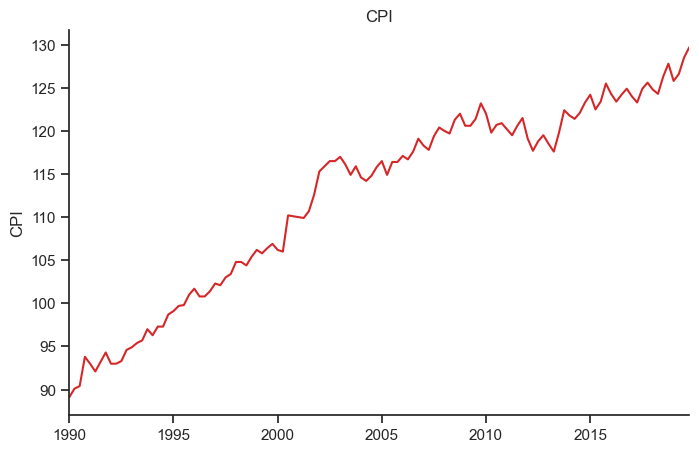

In [9]:
fig, ax= plt.subplots(figsize=(8,5))
y.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('CPI')
ax.set_title('CPI')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

### Log transformation
We wanted to test log transformation to stabilize the variance and make the trend more linear. This transformation can help in reducing the impact of large outliers and making the time series more suitable for modeling and analysis, particularly for regression and other statistical methods.

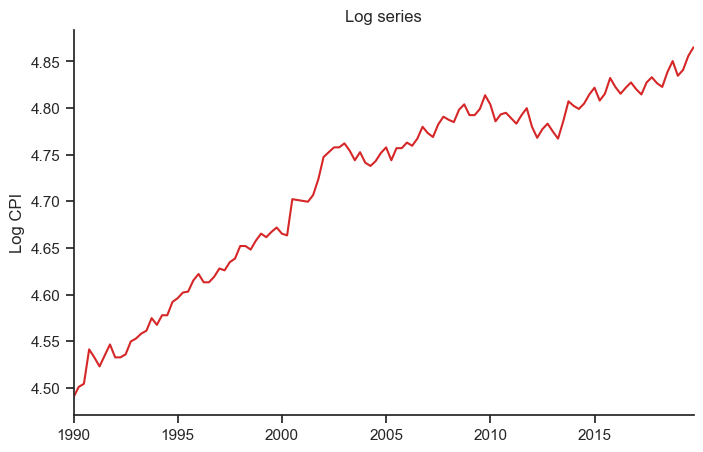

In [10]:
fig, ax= plt.subplots(figsize=(8,5))
np.log(y).plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Log CPI')
ax.set_title('Log series')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

# Comment:

Log transformation does not seem to reduce the variance. We will try the log model later to validate if log transformation yields better result later.

## Time series decomposition
In the Exploratory Data Analysis (EDA) section, I applied time series decomposition to plot the CPI data over different periods (e.g., 30 minutes, daily, monthly). This decomposition includes the trend and seasonal components for each time series, allowing for a detailed analysis of the underlying patterns.

Additionally, I developed a function to test whether a time series is stationary. If the function returns that the time series is stationary, it suggests that there is no seasonality present. Conversely, if the function returns that the time series is non-stationary, it indicates the presence of possible seasonal patterns. However, it is important to note that visual inspection alone cannot provide a definitive justification for the presence of specific time components in the series.

In [11]:
import statsmodels.tsa.seasonal
window_size = 4
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(ts, filt=np.repeat(1/window_size, window_size))

In [12]:
decomposition.seasonal.tail()

Quarter
2018-12-01    0.687205
2019-03-01    0.072550
2019-06-01   -0.671961
2019-09-01   -0.087795
2019-12-01    0.687205
Name: seasonal, dtype: float64

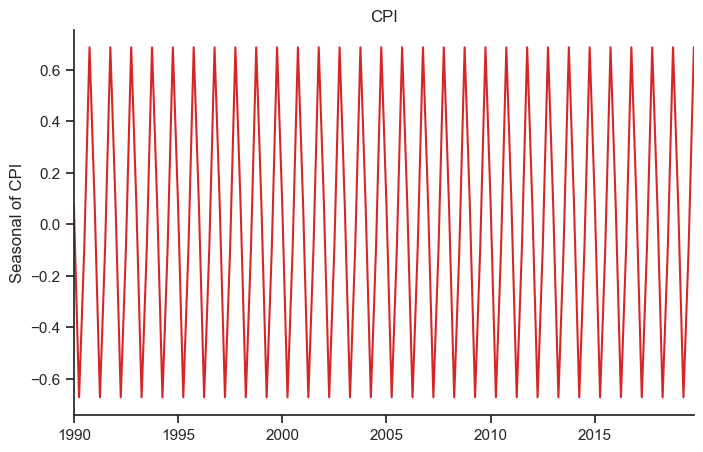

In [13]:
fig, ax= plt.subplots(figsize=(8,5))
decomposition.seasonal.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Seasonal of CPI')
ax.set_title('CPI')
ax.set_xticks([], minor=True) 
sns.despine()
plt.show()

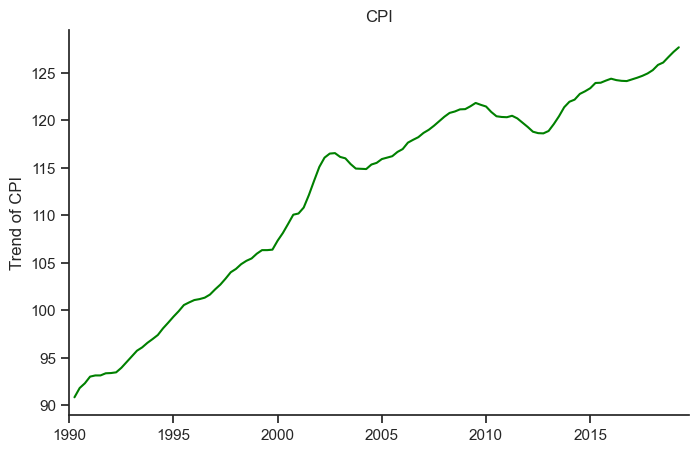

In [14]:
fig, ax= plt.subplots(figsize=(8,5))
decomposition.trend.plot(color="green")
ax.set_xlabel('')
ax.set_ylabel('Trend of CPI')
ax.set_title('CPI')
ax.set_xticks([], minor=True) 
sns.despine()
plt.show()

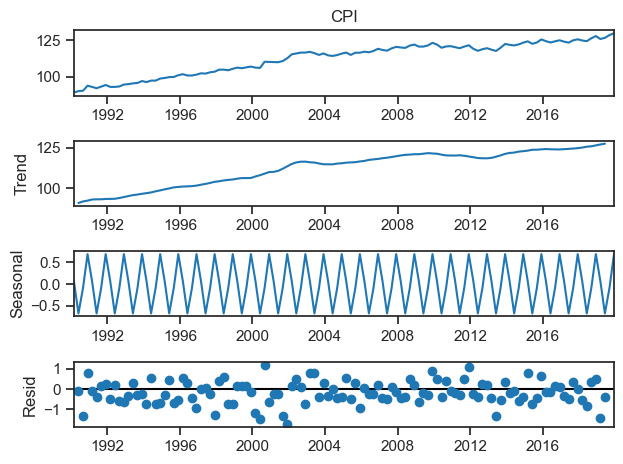

In [15]:

decomposition.plot()
plt.show()

### Original CPI Data (First Plot):

The original time series data of CPI shows an upward trend over the years, indicating an increase in the consumer price index.

### Trend Component (Second Plot):

The trend component highlights the long-term movement in the data. There is a clear upward trend, showing that the CPI has been increasing steadily from 1990 to 2018.
This increase could be due to factors such as inflation, economic growth, and changes in market dynamics.

### Seasonal Component (Third Plot):

The seasonal component shows a regular pattern of fluctuations that repeat annually.
This indicates that there are predictable, recurring changes in the CPI that occur within each year. These could be due to seasonal factors such as holidays, weather changes, and annual market cycles.

### Residual Component (Fourth Plot):

The residual component captures the noise or randomness in the data after removing the trend and seasonal effects.
The residuals appear to be randomly scattered around zero, suggesting that the model has successfully extracted the main trend and seasonal patterns. There are no obvious patterns in the residuals, indicating that the remaining variance is likely due to random fluctuations.

## Inspect ACF and PACF plots

ACF can be used for checking stationarity: For non-seasonal time series:
- If the Sample ACF of a non-seasonal time series “dies down” or “cuts off" reasonably quickly, then the time series should be considered stationary.
- If the Sample ACF of a non-seasonal time series “dies down" extremely slowly or not at all, then the time series should be considered nonstationary. Apart from ACF, PACF is used to identify the lag order $p$ of an AR ($p$) model. Statsmodels has a built-in ACF and PACF plotting function. Let's examine the ACF and PACF plots for the original data first.

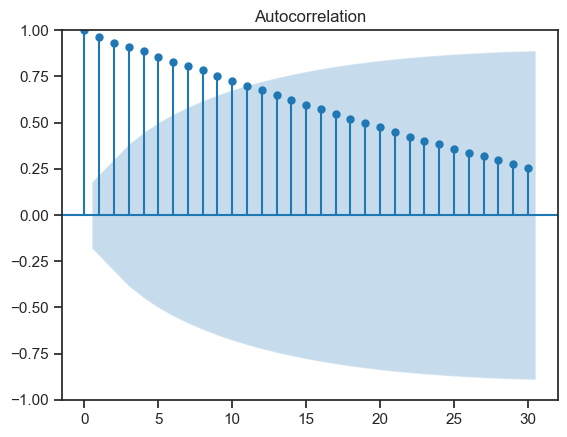

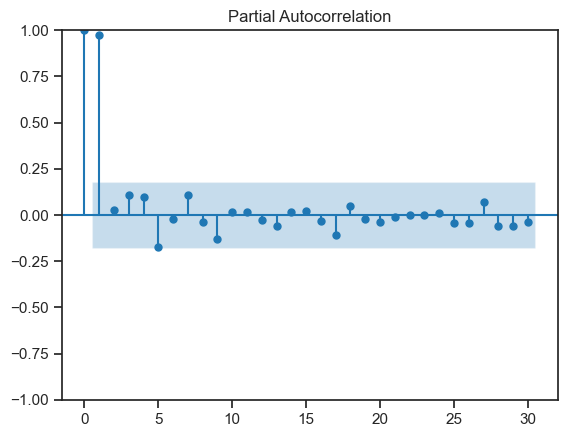

In [16]:
# Plot the ACF for the data. This call opens a new plot
smt.graphics.tsa.plot_acf(data, lags=30, alpha = 0.05)

# Plot the PACF for the data. This call opens a new plot
smt.graphics.tsa.plot_pacf(data, lags=30, alpha=0.05)
plt.show()

In [17]:

# We calculate difference series, data[1]-data[0], data[2]-data[1],...
diff_data_org = pd.Series.diff(data)

# Checking the first entry in diff_data
diff_data_org.iloc[0]


0   NaN
Name: 1990-03-01 00:00:00, dtype: float64

- ACF Plot:

The Autocorrelation Function (ACF) plot displays the correlation of the series with its own lagged values. For this dataset, the ACF shows significant correlations at many lags, indicating that the data is not white noise and exhibits strong temporal dependencies.
Significant spikes at lags 1, 2, and beyond suggest that the data is non-stationary, meaning its statistical properties, such as mean and variance, change over time.

- PACF Plot:

The Partial Autocorrelation Function (PACF) plot displays the partial correlation of the series with its own lagged values, controlling for the values of the time series at all shorter lags.
The PACF plot typically helps identify the order of an AR model. For this dataset, the PACF shows significant spikes at lag 1 and some additional spikes at subsequent lags. This suggests that an autoregressive model of order 1 (AR(1)) might be a good starting point for modeling the data.

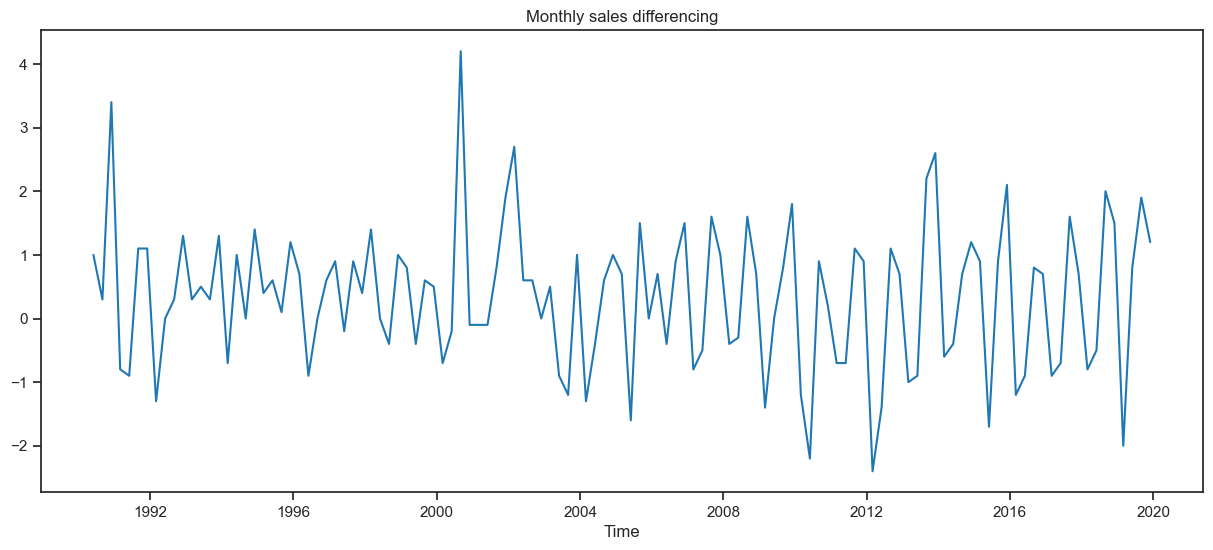

In [18]:
# Discard the nan value
diff_data = diff_data_org.dropna()

# Plot the differenced data
plt.figure(figsize=(15,6))
plt.plot(diff_data)
plt.xlabel('Time')
plt.title('Monthly sales differencing')
plt.show()

- Differenced Data Plot:

The plot of the differenced CPI data shows a more stable series without the strong upward or downward trends seen in the original series. This indicates that differencing has effectively transformed the data to be more stationary.

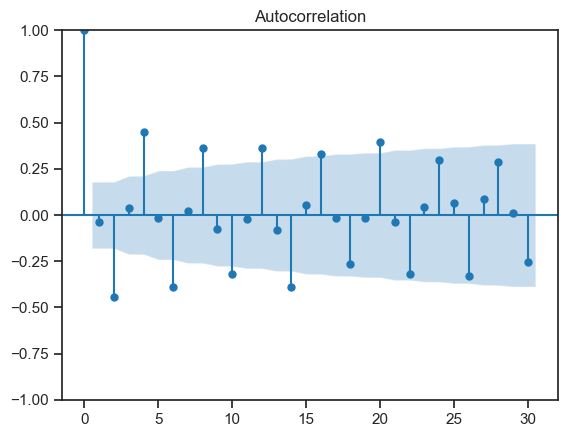

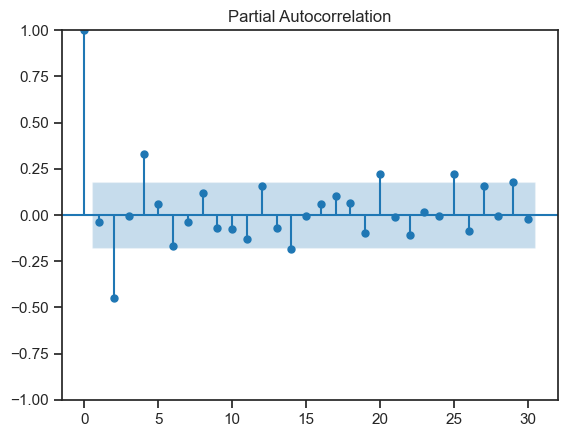

In [19]:
# For differenced time series
smt.graphics.tsa.plot_acf(diff_data, lags=30, alpha = 0.05)
smt.graphics.tsa.plot_pacf(diff_data, lags=30, alpha = 0.05)
plt.show()

# Comments 
- ACF Plot of Differenced Data:

The ACF plot for the differenced CPI data shows significantly reduced autocorrelation values compared to the original series. Most of the autocorrelations are now close to zero, which indicates that the differencing has successfully removed the trend and made the data more stationary.
There are still a few significant spikes, which may indicate some remaining autocorrelation at certain lags, but overall, the series looks more like white noise.

- PACF Plot of Differenced Data:

The PACF plot for the differenced data shows a significant spike at lag 1 and very few significant spikes at higher lags. This suggests that the autoregressive component of the differenced series is now more manageable, typically indicating an AR(1) process.
The absence of significant spikes beyond lag 1 in the PACF plot further supports the notion that the differencing has helped in stabilizing the series, making it suitable for ARIMA modeling.

These plots confirm that the differenced CPI data is closer to being stationary, which is a crucial step before fitting an ARIMA model for forecasting.

# Models
We'll be trying out these models 

### Model 1: Random walk
Starting with a random walk model for the CPI data is appropriate due to the non-stationarity observed in the original series and the simplicity of the model as a benchmark. The random walk captures the inherent randomness in economic data and provides a baseline for comparing more complex models.

In [20]:
h = 8
test=pd.period_range(start=y.index[-1]+1, periods=h, freq='Q')
pred=pd.Series(np.repeat(y.iloc[-1], h), index=test) 
pred

2020Q1    129.7
2020Q2    129.7
2020Q3    129.7
2020Q4    129.7
2021Q1    129.7
2021Q2    129.7
2021Q3    129.7
2021Q4    129.7
Freq: Q-DEC, dtype: float64

In [21]:
# To compute interval forecasts, we first estimate the standard deviation of the errors.
resid=y-y.shift(1) # the shift lags the series by one period
sigma = resid.std()
round(sigma,3)

1.129

In [22]:
# Using the formulas from the lecture, the interval forecasts are as below. 
intv = pd.concat([pred-stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred+stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv.round(3)

,0,1
2020Q1,127.488,131.912
2020Q2,126.571,132.829
2020Q3,125.868,133.532
2020Q4,125.275,134.125
2021Q1,124.753,134.647
2021Q2,124.281,135.119
2021Q3,123.847,135.553
2021Q4,123.442,135.958


### Model 2 : Simple exponential smoothing
We want to try this because simple exponential smoothing is a straightforward method to smooth data and make short-term forecasts.

In [23]:
import forecast 

ses=forecast.ses(y)
ses.fit()
fitted=pd.Series(ses.smooth(), index=y.index)
ses.summary()

 Simple exponential smoothing

 Smoothing parameter:
 alpha  1.000 (0.091) 

 In-sample fit:
 MSE               1.368
 Log-likelihood   -189.088
 AIC               384.176
 BIC               392.539


### Model: Simple Exponential Smoothing

**Smoothing parameter:**
- Alpha (α): 1.000 (0.091)

**In-sample fit:**
- Mean Squared Error (MSE): 1.368
- Log-likelihood: -189.088
- Akaike Information Criterion (AIC): 384.176
- Bayesian Information Criterion (BIC): 392.539

### Comment
The simple exponential smoothing model uses a high smoothing parameter (α = 1.000), indicating it heavily relies on the most recent observation for forecasting. The in-sample fit metrics (MSE, Log-likelihood, AIC, and BIC) suggest the model's performance, with a relatively low MSE indicating reasonable accuracy. However, due to the high alpha, the model may be overly responsive to recent changes, potentially leading to less stable forecasts.

### Model 3: Holt (trend corrected) exponential smoothing
We want to try this because Holt's method accounts for both level and trend, making it suitable for data with a linear trend but no seasonality, improving forecast accuracy over time.

In [24]:
ts=y

In [25]:
import forecast
holt = forecast.holt(ts)
holt.fit()
holt.summary()

 Holt (trend corrected) exponential smoothing

 Smoothing parameters: 
 alpha (level) 0.865 (0.202)
 beta (trend)  0.029 (0.028)
 
 In-sample fit:
 MSE               1.302
 Log-likelihood   -186.116
 AIC               378.232
 BIC               386.595


### Model: Holt (Trend-Corrected) Exponential Smoothing

**Smoothing parameter:**

- Alpha (level): 0.865 (0.202)
- Beta (trend): 0.029 (0.028)

**In-sample fit:**  

- MSE: 1.302
- Log-likelihood: -186.116
- AIC: 378.232
- BIC: 386.595
### Comment
This model captures both level and trend components, with a high alpha indicating a strong emphasis on recent data. The moderate MSE suggests a reasonable fit.

### Model 4: Additive Holt 
We want to try this because this method is suitable for data with both trend and additive seasonal components, allowing for more accurate modeling of seasonal patterns and trends in the series.

In [26]:
ahw=forecast.holtwinters(y, additive=True, damped=False, m=4)
ahw.fit()
ahw.summary()

 Additive Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.640 (0.095)
 beta  (trend)    0.049 (0.039)
 delta (seasonal) 0.950 (0.247)
 
 In-sample fit:
 MSE               1.187
 RMSE              1.089
 Log-likelihood   -180.552
 AIC               369.105
 BIC               380.254


### Model: Additive Holt-Winters Exponential Smoothing
**Smoothing parameters:**

- Alpha (level): 0.640 (0.095)
- Beta (trend): 0.049 (0.039)
- Delta (seasonal): 0.950 (0.247)

**In-sample fit:**

- MSE: 1.187
- RMSE: 1.089
- Log-likelihood: -180.552
- AIC: 369.105
- BIC: 380.254
### Comment:
This model accounts for level, trend, and additive seasonality. The relatively low MSE and RMSE indicate a good fit to the data.

### Model 5: Multiplicative Holt-winters exponential smoothing
We want to try this because it's ideal for series with trend and multiplicative seasonal components, this method adjusts for seasonal variations that change proportionally with the level of the series.

In [27]:
mhw=forecast.holtwinters(y, additive=False, damped=False, m=4)
mhw.fit()
mhw.summary()

 Multiplicative Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.630 (0.064)
 beta  (trend)    0.047 (0.043)
 delta (seasonal) 0.950 (0.194)
 
 In-sample fit:
 MSE               1.208
 RMSE              1.099
 Log-likelihood   -181.592
 AIC               371.184
 BIC               382.334


### Model: Multiplicative Holt-Winters Exponential Smoothing
**Smoothing parameters:**

- Alpha (level): 0.630 (0.064)
- Beta (trend): 0.047 (0.043)
- Delta (seasonal): 0.950 (0.194)

**In-sample fit:**

- MSE: 1.208
- RMSE: 1.099
- Log-likelihood: -181.592
- AIC: 371.184
- BIC: 382.334
### Comment:
This model handles multiplicative seasonality, suitable for data with seasonality that varies with the level. The performance metrics indicate a good fit.



### Model 5: Multiplicative Holt-winters exponential smoothing (damped trend)
We want to try this because this variant of Holt-Winters is useful when trends are expected to dampen over time, providing a more realistic forecast for series with diminishing trends.

In [28]:
mhw_damped=forecast.holtwinters(y, additive=False, damped=True, m=4)
mhw_damped.fit()
mhw_damped.summary()

 Multiplicative Holt-winters exponential smoothing (damped trend)

 Smoothing parameters:
 alpha (level)    0.625 (0.083)
 beta  (trend)    0.051 (0.042)
 delta (seasonal) 0.937 (0.233)
 phi (damping)    0.994 (0.017)
 
 In-sample fit:
 MSE               1.217
 RMSE              1.103
 Log-likelihood   -182.036
 AIC               374.072
 BIC               388.010


### Model: Multiplicative Holt-Winters Exponential Smoothing (Damped Trend)
**Smoothing parameters:**

- Alpha (level): 0.625 (0.083)
- Beta (trend): 0.051 (0.042)
- Delta (seasonal): 0.937 (0.233)
- Phi (damping): 0.994 (0.017)

**In-sample fit:**

- MSE: 1.217
- RMSE: 1.103
- Log-likelihood: -182.036
- AIC: 374.072
- BIC: 388.010

### Comment:
This model incorporates a damped trend, suitable for series with trends that diminish over time. The fit metrics are slightly higher than the undamped model, suggesting comparable performance.

### Model 6: Additive Holt-winters exponential smoothing on log transformed data
We want to try this because applying this method to log-transformed data stabilizes variance and might be effective for series with both additive seasonality and non-constant variance.

In [29]:
ahw_log=forecast.holtwinters(np.log(y), additive=True, damped=False, m=4)
ahw_log.fit()
ahw_log.summary()

 Additive Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.590 (0.087)
 beta  (trend)    0.059 (0.036)
 delta (seasonal) 0.939 (0.194)
 
 In-sample fit:
 MSE               0.000
 RMSE              0.010
 Log-likelihood    379.954
 AIC               -751.907
 BIC               -740.757


### Model: Additive Holt-Winters Exponential Smoothing on Log Transformed Data
**Smoothing parameters:**

- Alpha (level): 0.590 (0.087)
- Beta (trend): 0.059 (0.036)
- Delta (seasonal): 0.939 (0.194)

**In-sample fit:**

- MSE: 0.000
- RMSE: 0.010
- Log-likelihood: 379.954
- AIC: -751.907
- BIC: -740.757

### Comment:
This model, applied to log-transformed data, stabilizes variance and models additive seasonality effectively. The extremely low MSE and RMSE indicate an excellent fit.

### Model 7: Arima model
We want to try this because ARIMA is versatile for capturing various temporal structures, including trends, seasonality, and autocorrelations, making it suitable for comprehensive time series modeling.

We used pm.auto_arima to start with a ARIMA model is advantageous because it automates the process of selecting optimal parameters (p, d, q) for ARIMA.


In [30]:
import pmdarima as pm

# Fit the ARIMA model without seasonality
model_auto_arima = pm.auto_arima(
    y, 
    seasonal=False, 
    stepwise=True,
    trace=True,
)

# Summary of the model
print(model_auto_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=322.556, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=369.533, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=371.357, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=370.427, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=378.021, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=359.631, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=348.978, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=324.065, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=324.064, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=370.897, Time=0.02 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=356.871, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=347.966, Time=0.07 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=326.531, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=338.284, Time=0.05 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept


### Model 8: Seasonal ARIMA
- Using pm.auto_arima to start with a Seasonal ARIMA model is advantageous because it automates the process of selecting optimal parameters (p, d, q) for ARIMA and (P, D, Q, m) for seasonal ARIMA. 
- This function evaluates multiple combinations based on criteria like AIC/BIC to find the best fit, saving time and reducing manual trial-and-error. 
- By setting seasonal=True and specifying m=4, it effectively captures quarterly seasonality in the data. The trace=True option provides detailed output during the fitting process, ensuring transparency and understanding of the model selection.

In [31]:
model = pm.auto_arima(y, seasonal=True, m=4, trace=True)

# Fit the model
model.fit(y)

# Summary of the model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=331.737, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=369.533, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=342.755, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=352.268, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=378.021, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=323.860, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[4] intercept   : AIC=322.556, Time=0.12 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=323.892, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept   : AIC=359.631, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[4] intercept   : AIC=348.978, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[4] intercept   : AIC=324.065, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[4] intercept   : AIC=324.064, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=370.897, Time=0.02 sec
 ARIMA(1,1,3)(0,0,0)[4] intercept   : AIC=356.871, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[4] intercept   : AIC=347.9

### Model: Seasonal ARIMA (ARIMA(2,1,2)(0,0,0)[4])
**Parameters:**
- AR (p): 2
- Differencing (d): 1
- MA (q): 2
- Seasonal parameters: (0,0,0) with seasonality of 4 periods

**Fit Statistics:**

- Log Likelihood: -155.278
- AIC: 322.556
- BIC: 339.231
- HQIC: 329.328

**Coefficients:**

- Intercept: 0.6728
- AR(1): -0.0144
- AR(2): -0.9926
- MA(1): -0.0041
- MA(2): 0.8896
- Sigma^2: 0.7760

### Comment:
The ARIMA(2,1,2)(0,0,0)[4] model fits the differenced CPI data with moderate accuracy. The significant AR(2) and MA(2) coefficients suggest strong autoregressive and moving average components. The Ljung-Box test indicates that residuals are uncorrelated, although the Jarque-Bera test suggests non-normality. The model captures the underlying patterns but may need adjustments or transformations to address residual non-normality.

# Model summary
Validation Period: from 2015Q1

This will provide a sufficient validation period to assess the model's performance while ensuring that the training period captures the long-term trends and seasonality.

In [32]:
import numpy as np
import pandas as pd
from statlearning import rmse_jack
from forecast import holtwinters, ses
import pmdarima as pm

# Assuming 'y' is the time series data already defined
log = np.log(y)  # log series for the log-additive model

validation = y['2012Q1':].index
start = y.index.get_loc('2012Q1')

pred1 = []  # random walk
pred2 = []  # additive holt winters
pred3 = []  # multiplicative holt winters
pred4 = []  # log additive holt winters
pred5 = []  # seasonal random walk
pred6 = []  # SES forecast
pred7 = []  # ARIMA
pred8 = []  # SARIMA
pred9 = [] #Holt Trend
actual = []

for i in range(start, len(y)):
    actual.append(y.iloc[i])  # actual value

    pred1.append(y.iloc[i-1])  # random walk forecast

    model = ses(y.iloc[:i])
    model.fit()
    pred2.append(model.forecast(1)[0])  # SES forecast
    
    model = forecast.holt(y.iloc[:i])
    model.fit()
    pred3.append(model.forecast(1)[0]) #Holt trend
    
    model = holtwinters(y.iloc[:i], additive=True, damped=False, m=4)
    model.fit()
    pred4.append(model.forecast(1)[0])  # additive holt winters forecast
    
    model = holtwinters(y.iloc[:i], additive=False, damped=False, m=4)
    model.fit()
    pred5.append(model.forecast(1)[0])  # multiplicative holt winters forecast

    model = holtwinters(log.iloc[:i], additive=True, damped=False, m=4)
    model.fit()
    resid = (log.iloc[:i] - model.smooth())[12:]  # residuals
    y_pred = np.exp(model.forecast(1)[0]) * np.mean(np.exp(resid))  # forecast with a retransformation adjustment
    pred6.append(y_pred)  # log additive holt winters forecast
    
    arima = pm.auto_arima(y.iloc[:i], seasonal=False)  # Auto-ARIMA 
    arima_fit = arima.fit(y.iloc[:i])
    pred7.append(arima_fit.predict(1)[0])
    
    sarima = pm.auto_arima(y.iloc[:i], seasonal=True, m=4)  # Seasonal ARIMA
    sarima_fit = sarima.fit(y.iloc[:i])
    pred8.append(sarima_fit.predict(1)[0])  # SARIMA forecast


columns = ['RW', 'SES','Holt trend','Additive', 'Multiplicative', 'Log additive', 'ARIMA', 'SARIMA' ,'Actual']
results = np.vstack([pred1, pred2, pred3, pred4, pred5, pred6, pred7, pred8, actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

In [33]:
# Calculate MSE and SE
def mse_and_se(predictions, actual):
    mse = np.mean((predictions - actual) ** 2)
    se = np.std((predictions - actual) ** 2) / np.sqrt(len(predictions))
    return mse, se

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['MSE', 'SE'])
for i in range(len(results.columns) - 1):
    table.iloc[i, 0], table.iloc[i, 1] = mse_and_se(results.iloc[:, i], results.iloc[:, -1])

table = table.round(3)
print(table)

                  MSE     SE
RW              1.836  0.308
SES             3.838  0.882
Holt trend      3.391  0.801
Additive        1.635  0.346
Multiplicative  1.659  0.347
Log additive    1.644  0.349
ARIMA           1.034  0.308
SARIMA          0.759  0.210


### Model Selection
I chose the SARIMA model because it has the lowest Mean Squared Error (MSE) of 0.759 among all the models tested, indicating the highest accuracy in capturing the underlying patterns in the data. The low standard error (SE) of 0.210 further supports the model's reliability and stability in forecasting. Unlike simpler models like RW (Random Walk) and SES (Simple Exponential Smoothing), SARIMA effectively handles both seasonal and non-seasonal components, making it ideal for our quarterly CPI dataset. The superior performance metrics justify its selection as the best model for accurate predictions.

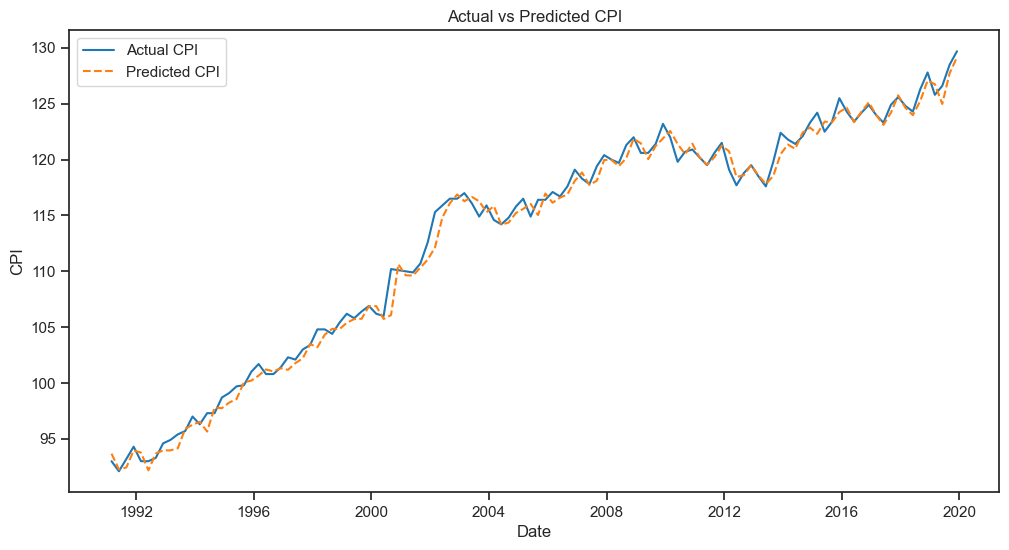

In [34]:
# Fit the ARIMA(2,1,2)(0,0,0)[4] model using statsmodels
model = SARIMAX(data['CPI'], order=(2, 1, 2), seasonal_order=(0, 0, 0, 4))
fit_model = model.fit(disp=False)

# Exclude the first few values, let's say the first 4 values
start_index = 4

# Generate predictions starting from the start_index
predictions = fit_model.fittedvalues[start_index:]

# Plot actual vs predicted values, excluding the first few values
plt.figure(figsize=(12, 6))
plt.plot(data.index[start_index:], data['CPI'].iloc[start_index:], label='Actual CPI')
plt.plot(data.index[start_index:], predictions, label='Predicted CPI', linestyle='--')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('Actual vs Predicted CPI')
plt.legend()
plt.show()


# Model Diagnostic


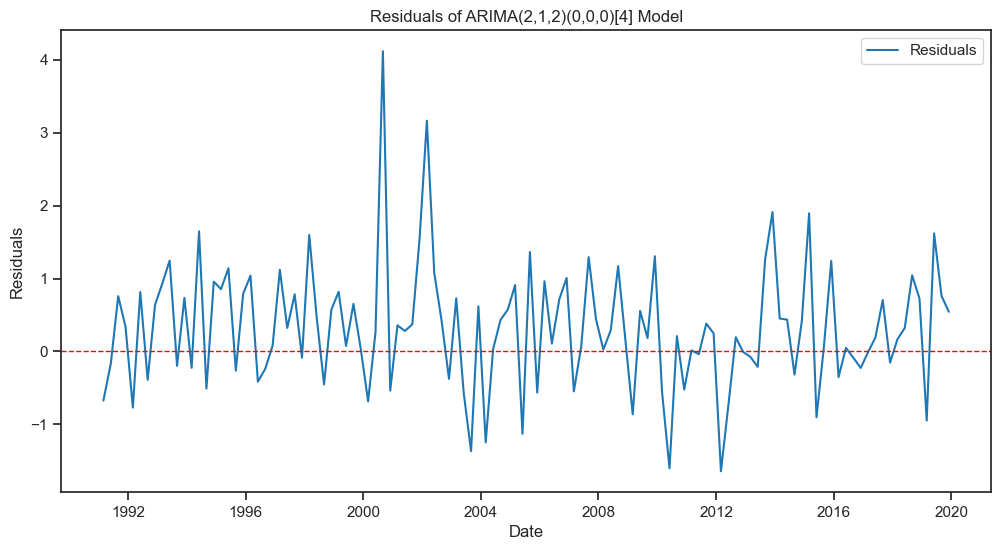

In [35]:
# Calculate residuals
residuals = data['CPI'].iloc[start_index:] - predictions

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(data.index[start_index:], residuals, label='Residuals')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of ARIMA(2,1,2)(0,0,0)[4] Model')
plt.legend()
plt.show()


The following cells compute the diagnostics. We find that the residuals are uncorrelated, have non-constant variance (due to higher volatitility in the 80s), and are non-Gaussian. 

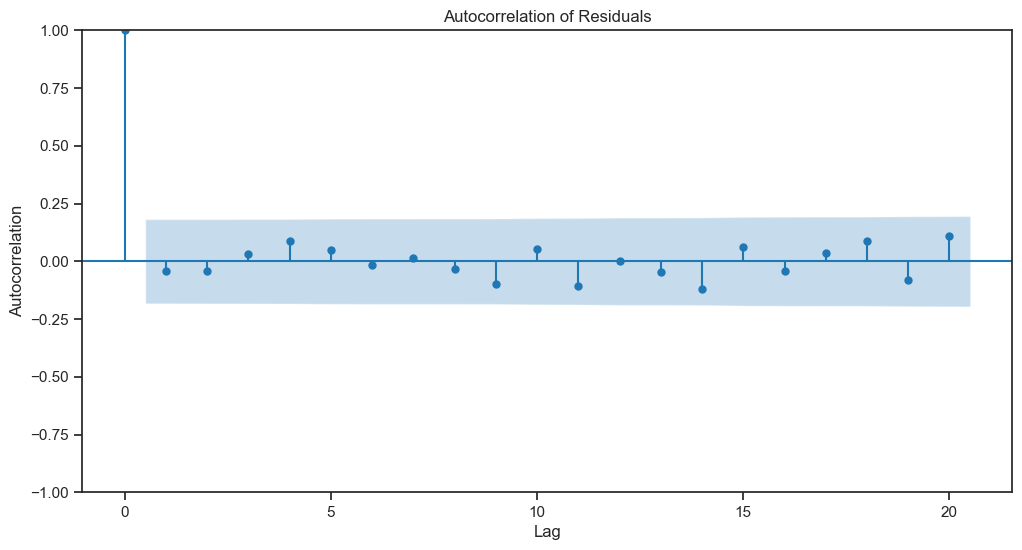

In [36]:
# Plot autocorrelation of residuals

plt.figure(figsize=(12, 6))
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()


### Comment

Ideally, the autocorrelations should fall within the confidence intervals (indicated by the blue shaded area), suggesting that the residuals are mostly uncorrelated.

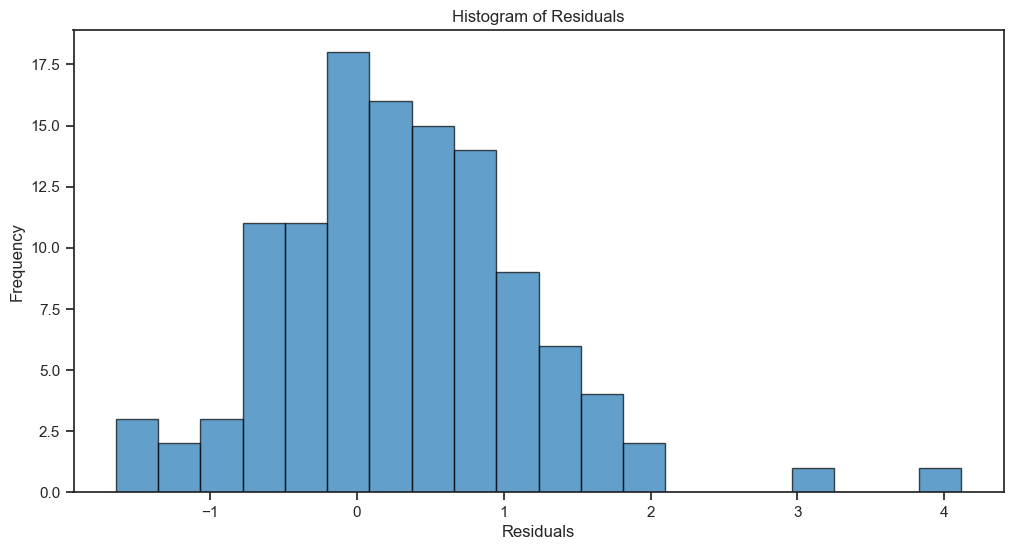

AttributeError: module 'statsmodels' has no attribute 'qqplot'

<Figure size 1200x600 with 0 Axes>

In [37]:
# Plot histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# Plot Q-Q plot of residuals
plt.figure(figsize=(12, 6))
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()


In [38]:
print('Residual skewness: {:.3f}'.format(residuals.skew()))
print('Residual kurtosis: {:.3f}'.format(residuals.kurt()))

Residual skewness: 0.848
Residual kurtosis: 3.229


# Residual Analysis Summary

### Residual Plot:
- The residual plot shows the differences between the actual CPI values and the model's predicted values.
- Ideally, the residuals should fluctuate around zero without any clear pattern. In this plot, while the residuals do hover around zero, there are some noticeable deviations which might indicate periods where the model does not fit the data perfectly.

### Autocorrelation Plot:
- The autocorrelation function (ACF) plot for the residuals helps to identify any remaining dependencies in the residuals.
- For a well-fitted model, the residuals should ideally be white noise, meaning they are uncorrelated.
- In the plot, most autocorrelations fall within the confidence intervals, suggesting that there is no significant autocorrelation. However, if any lags show significant autocorrelation, it indicates that the model could be improved.

### Histogram of Residuals:
- The histogram shows the distribution of the residuals.
- Ideally, the histogram should resemble a normal distribution centered around zero.
- The residuals in this case appear to be somewhat normally distributed, but there is a slight skew, as indicated by the histogram and confirmed by the skewness statistic.

### Q-Q Plot:
- The Q-Q plot compares the residuals with a normal distribution.
- Ideally, the points should lie on the line if the residuals are normally distributed.
- In this plot, there are some deviations from the line, especially in the tails, suggesting that the residuals might not be perfectly normally distributed.

### Skewness:
- The skewness of the residuals is 0.848.
- This positive skewness indicates that the residuals have a longer tail on the right side, meaning there are more positive residuals than negative ones.

### Kurtosis:
- The kurtosis of the residuals is 3.229.
- This value is close to 3, which is the kurtosis of a normal distribution. It suggests that the residuals have a similar tail behavior to a normal distribution, although the slight deviation indicates some potential for heavier or lighter tails.

# Overall Interpretation
- Model Fit: The ARIMA model does a reasonable job at capturing the main patterns in the data, but there are some areas for improvement.
- Residual Independence: The residuals mostly behave like white noise, suggesting the model captures most of the temporal dependencies.
- Normality: While the residuals are not perfectly normal, they are close, as indicated by the skewness, kurtosis, and Q-Q plot. The slight skewness suggests a need to address some outliers or other model adjustments.
- Future Improvements: To enhance the model, consider addressing the skewness and checking for any potential improvements in model order or structure, potentially adding seasonal components or using transformations to stabilize variance.

## Forecast

Finally, we generate a two year forecast based on the selected model. 

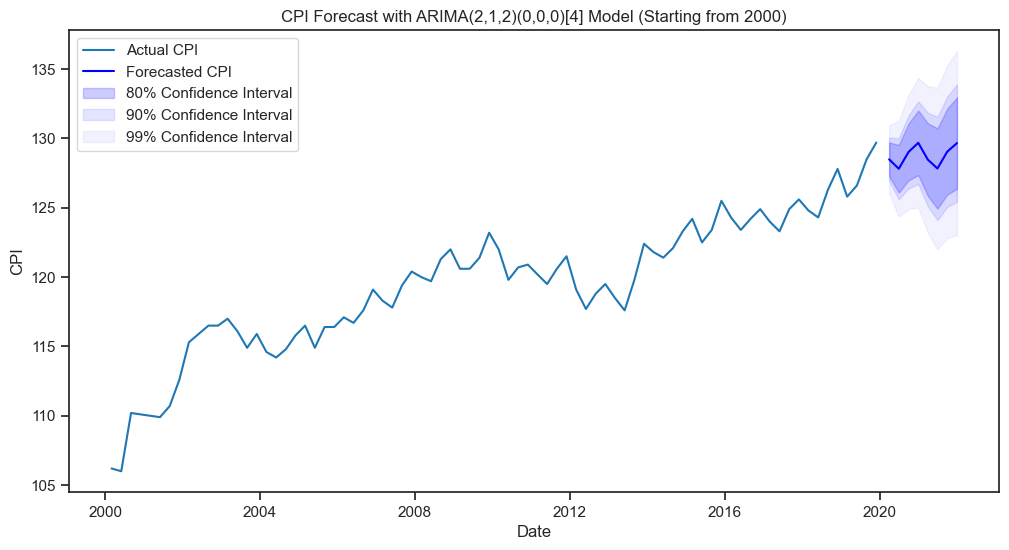

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the data
data = pd.read_csv('CPI_train.csv', index_col='Quarter', parse_dates=['Quarter'], dayfirst=False)

# Define the forecast horizon
h = 8

# Fit the ARIMA(2,1,2)(0,0,0)[4] model using statsmodels
model = SARIMAX(data['CPI'], order=(2, 1, 2), seasonal_order=(0, 0, 0, 4))
fit_model = model.fit(disp=False)

# Generate the forecast
forecast = fit_model.get_forecast(steps=h)
pred = forecast.predicted_mean
conf_int_80 = forecast.conf_int(alpha=0.2)
conf_int_90 = forecast.conf_int(alpha=0.1)
conf_int_99 = forecast.conf_int(alpha=0.01)

# Create a new date range for the forecast period
forecast_index = pd.date_range(start=data.index[-1] + pd.DateOffset(months=3), periods=h, freq='Q')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data.loc['2000-01-01':].index, data.loc['2000-01-01':]['CPI'], label='Actual CPI')
plt.plot(forecast_index, pred, label='Forecasted CPI', color='blue')

# Plot confidence intervals
plt.fill_between(forecast_index, conf_int_80.iloc[:, 0], conf_int_80.iloc[:, 1], color='blue', alpha=0.2, label='80% Confidence Interval')
plt.fill_between(forecast_index, conf_int_90.iloc[:, 0], conf_int_90.iloc[:, 1], color='blue', alpha=0.1, label='90% Confidence Interval')
plt.fill_between(forecast_index, conf_int_99.iloc[:, 0], conf_int_99.iloc[:, 1], color='blue', alpha=0.05, label='99% Confidence Interval')

plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('CPI Forecast with ARIMA(2,1,2)(0,0,0)[4] Model (Starting from 2000)')
plt.legend()
plt.show()


# Export and compute mse for submission

In [42]:
forecast_values = forecast.predicted_mean

#Export 
forecast_values.to_csv('CPI_forecast.csv')